In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics
from PIL import Image
import tensorflow as tf
from keras import layers

Number of images: 1297
Mean: 95.54356206630686
Geometric mean: 86.10314609508686
Median: 78.0
Min: 48
Max: 751


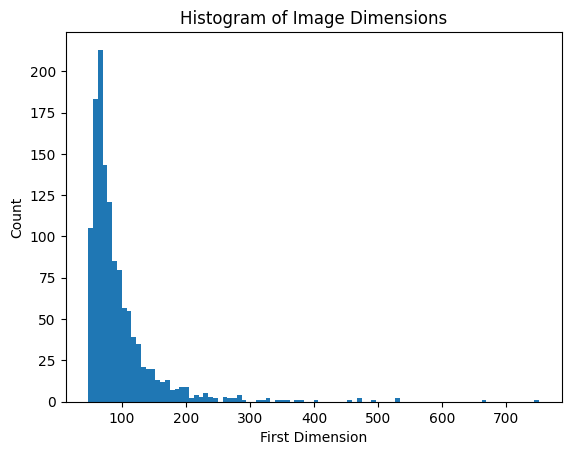

In [8]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"),
        os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        imgs = os.path.join(i, j, "images")
        if not os.path.exists(imgs):
            continue
        for img in os.listdir(imgs):

            img = os.path.join(imgs, img)

            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [9]:
confirmed_num = 0
for subfolder in os.listdir(dirs[0]):
    imgs = os.path.join(dirs[0], subfolder, "images")
    confirmed_num += len(os.listdir(imgs))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0
for subfolder in os.listdir(dirs[1]):
    if not os.path.exists(os.path.join(dirs[1], subfolder, "images")):
        continue
    imgs = os.path.join(dirs[1], subfolder, "images")
    rejected_images += [os.path.join(imgs, filename)
                        for filename in os.listdir(imgs)]
    rejected_num += len(os.listdir(imgs))
print("Number of artifact images:", rejected_num)

Number of meteor images: 885
Number of artifact images: 412


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized", "images"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(
        dirs[1], "synthesized", "images", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", "images", base_filename +
            "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of confirmed images:", confirmed_num)
print("Number of rejected images:", rejected_num)

In [ ]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
BATCH_SIZE = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    crop_to_aspect_ratio=True, # tinker with this
)

In [31]:
import pathlib
path='../mldataset'
data_dir = pathlib.Path(path)
for item in data_dir.glob("cropped/*"):
  print(item.name)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'))
for f in list_ds.take(2):
  print(f.numpy())

Artifacts
Meteors
b'..\\mldataset\\cropped\\Artifacts\\BE0004_20221123_162203_319970_detected'
b'..\\mldataset\\cropped\\Meteors\\FR000X_20230513_195407_211244_detected'
